In [3]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

In [8]:

def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)

class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dce_model = build_dce_net()


    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)


    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


# Loading already Trained Zero-Dce model.

In [9]:
zero_dce_model = ZeroDCE()
zero_dce_model.load_weights('model.h5')

In [10]:
def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image[:, :, :3] if image.shape[-1] > 3 else image
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    # print(image.shape, output_image.shape)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    # print(output_image.shape)
    # output_image = Image.fromarray(output_image)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

In [11]:
for image_file in ['7.jpeg']:   # Give path to image in the list of paths that you want to enhance. 
    original_image = Image.open(image_file)
    enhanced_image = infer(original_image)

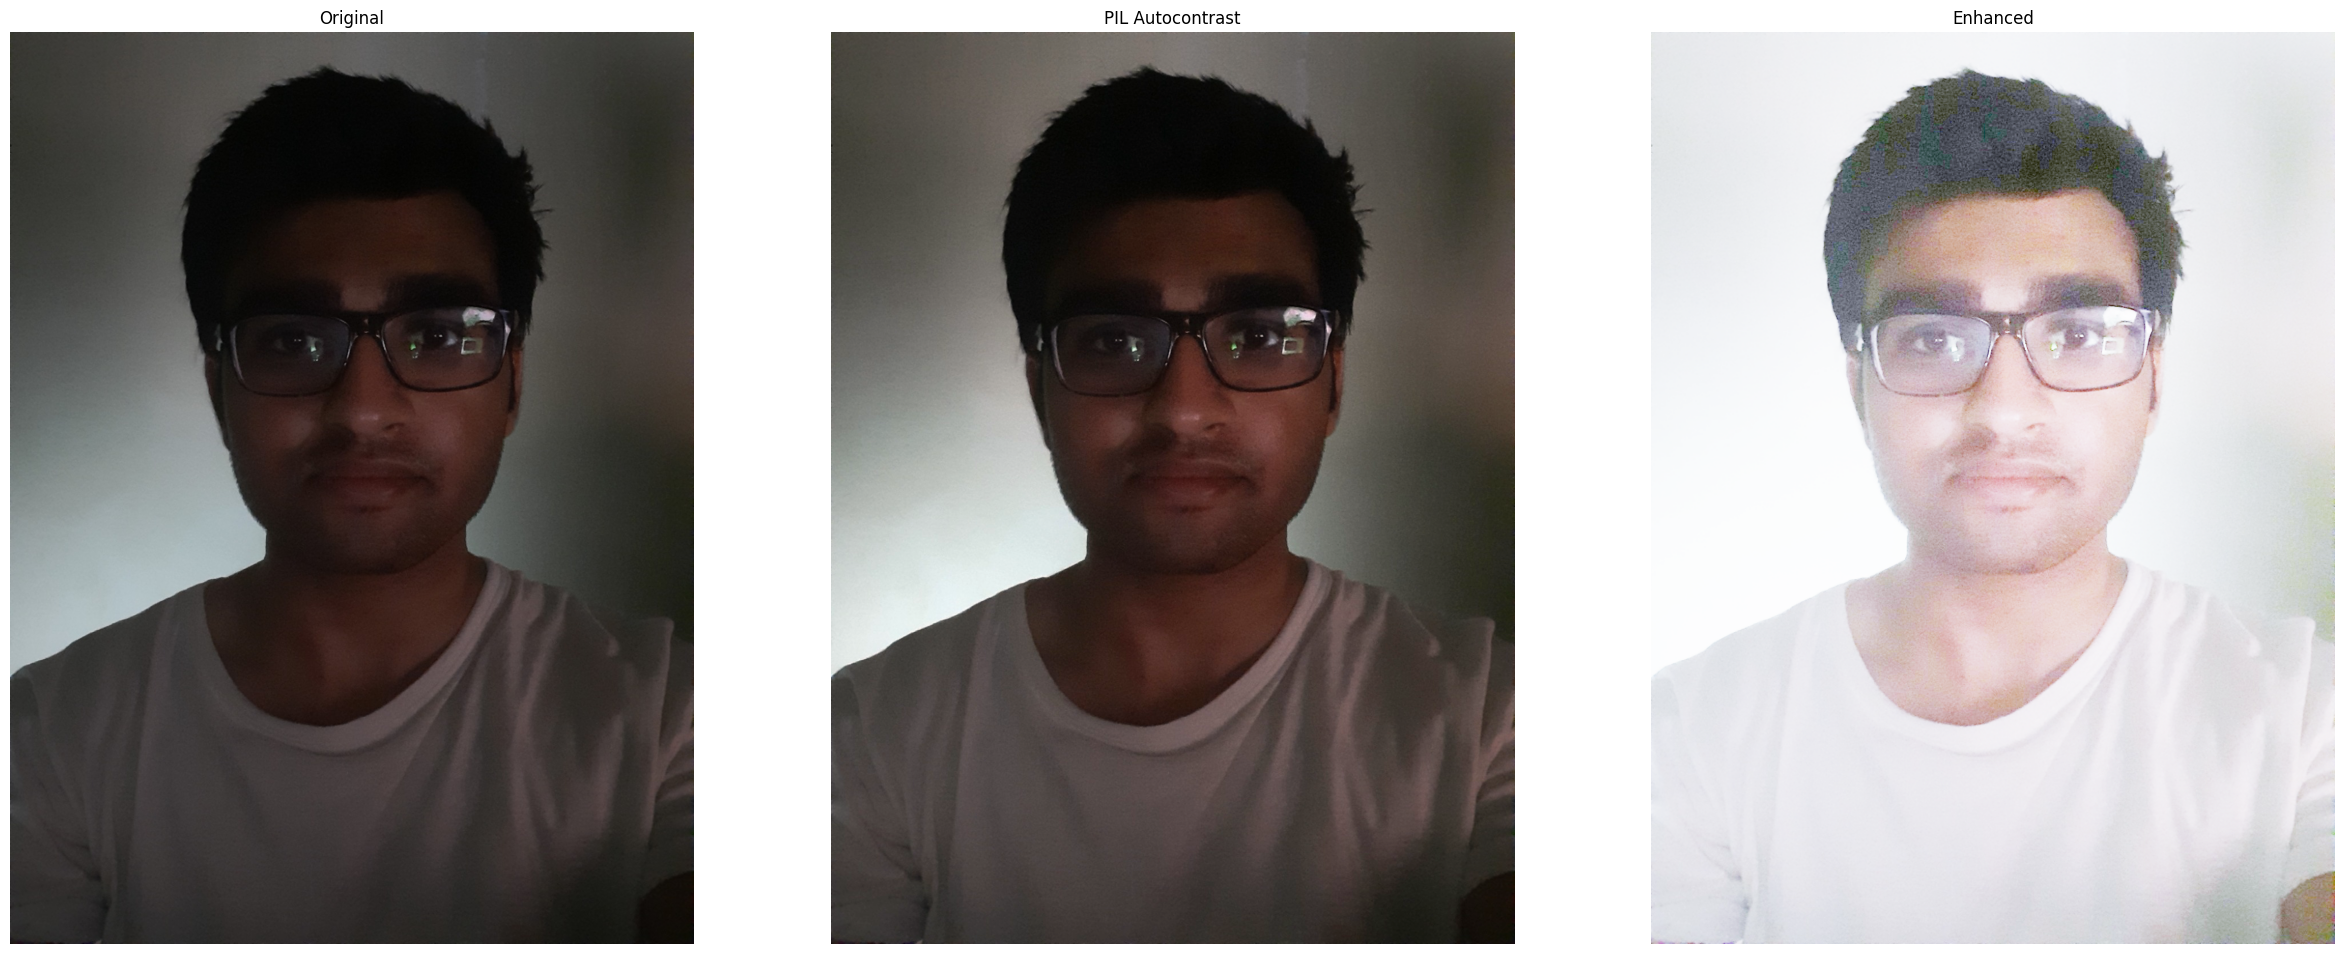

In [12]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

plot_results(
        [original_image, ImageOps.autocontrast(Image.fromarray(np.array(original_image)[:, :, :3])), enhanced_image],
        ["Original", "PIL Autocontrast", "Enhanced"],
        (30, 22),
    )

# mirnet

In [13]:
import numpy as np # array manipulation
from huggingface_hub import from_pretrained_keras # download the model
import keras # deep learning
from PIL import Image # Image processing
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from numpy import asarray

model = from_pretrained_keras("keras-io/lowlight-enhance-mirnet", compile=False)

config.json not found in HuggingFace Hub.
Fetching 11 files: 100%|██████████| 11/11 [00:00<?, ?it/s]


1/1 [==============================] - 16s 16s/step


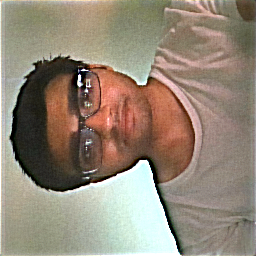

In [14]:
low_light_img = Image.open('divyesh.jpg').convert('RGB')
low_light_img = low_light_img.resize((256,256),Image.NEAREST)
image = asarray(low_light_img)
image = image.astype('float32') / 255.0
image = np.expand_dims(image, axis = 0)
output = model.predict(image) # model inference to enhance the low light pics
output_image = output[0] * 255.0
output_image = output_image.clip(0,255)
output_image = output_image.reshape((np.shape(output_image)[0],np.shape(output_image)[1],3))
output_image = np.uint32(output_image)
enhanced_image = Image.fromarray(output_image.astype('uint8'),'RGB') 
enhanced_image

# Using MIRNet for real time video Enhancement.

In [16]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (256,256))
    frame = frame.astype('float32') / 255.0
    frame = np.expand_dims(frame, axis = 0)
    output = model.predict(frame) 
    output_image = output[0] * 255.0
    output_image = output_image.clip(0,255)
    output_image = output_image.reshape((np.shape(output_image)[0],np.shape(output_image)[1],3))
    output_image = np.uint32(output_image)
    pim = Image.fromarray(output_image.astype('uint8'),'RGB')
    nimg = np. array(pim)
    ocvim = cv2. cvtColor(nimg, cv2.COLOR_RGB2BGR)
    cv2.imshow('frame', ocvim)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 8s 8s/step


### Using cv2 for low light Enhancement

In [20]:
cap = cv2.VideoCapture(0)
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        print("sfaasf")
    if ret == True:
        cv2.imshow('frame video',frame)
        r = frame[:,:,2]
        g = frame[:,:,1]
        b = frame[:,:,0]
        equalizedr =  cv2.equalizeHist(r)
        equalizedg =  cv2.equalizeHist(g)
        equalizedb =  cv2.equalizeHist(b)
        equalized = cv2.merge([equalizedb,equalizedg,equalizedr])
        cv2.imshow('enhanced video',equalized)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()